## Testsite for more advanced ML schemes

**TODO**:
- Get better images man!

In [1]:
# Different useful libraries
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helpers
from helpers import *
%run helpers.py

#### Get the augmented data

In [66]:
# Load images
cups, cup_size = import_images(path='henriks_images/augment_cup/')
boxes, box_size = import_images(path='henriks_images/augment_box/')

In [67]:
# Balance the data - we have more box data then cup data
#idx = np.random.randint(0, len(cups), len(cups))
#cups = np.asarray(cups)[idx, :, :, 0]
#boxes = np.asarray(boxes)[idx, :, :, 0]
cups = np.asarray(cups)[:, :, :, 0]
boxes = np.asarray(boxes)[:, :, :, 0]
cups.shape, boxes.shape

((594, 128, 128), (768, 128, 128))

### Basic data formatting
Splitting, normalization, pandas etc.

In [68]:
# Normalize advanced approach
(scaled_boxes, scaled_cups), scaler = normalize_2D(all_data=[boxes, cups], scaler_type='minmax')
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.0 0.9954128440366974 ) cups:( 0.10638297872340426 1.0000000000000002 )


In [69]:
# Normalize ez approach
scaled_boxes = boxes / 255
scaled_cups = cups / 255
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.06274509803921569 0.996078431372549 ) cups:( 0.13333333333333333 1.0 )


In [70]:
image_df = from_numpy_to_pd(data=[scaled_cups, scaled_boxes], labels=[0, 1])
train, test = train_test_split(image_df, test_size=0.2)

x_train = np.stack(train['data'], 0)
y_train = np.float32(train['label'])

x_test = np.stack(test['data'], 0)
y_test = np.float32(test['label'])

# For Keras this is required:
a, b, c = x_train.shape
x_train = x_train.reshape((a,b,c,1))
a, b, c = x_test.shape
x_test = x_test.reshape((a,b,c,1))


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1089, 128, 128, 1), (1089,), (273, 128, 128, 1), (273,))

### CNN - *conv. neural net time baby*!

***NB!*** Since we are for now only doing binary classification:
```
1. Change Categorical Cross Entropy to Binary Cross Entropy since your output label is binary.
2. Change Softmax to Sigmoid since Sigmoid is the proper activation function for binary data
```

Good sources:

- CONVNET on MINST: https://keras.io/examples/vision/mnist_convnet/
- Binary classification: https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

In [71]:
input_shape = (128, 128, 1)

cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

batch_size = 124
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history = cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[early_stop, PrintDot()]
            )


..................................................

,loss,accuracy,val_loss,val_accuracy,epoch
49,0.092322,0.97551,0.169568,0.954128,49


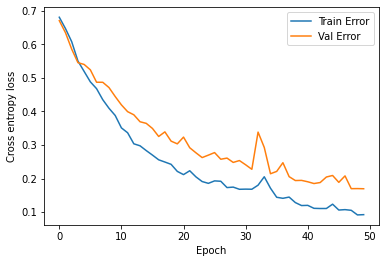

In [73]:
show_final_score(cnn_history)

**But this was easy! Using valiadtion data from the dataset itself**

In [11]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08092372119426727
Test accuracy: 0.9823232293128967


#### Test results
**Simple** Runs: with batch size 32, epochs 15
- Using softmax in output layer and sparse_categorical_crossentropy loss:\
    ```[Test loss: 0.050683144479990005, Test accuracy: 0.9806397557258606]```
- Trying the sigmoid output and sparse_categorical_crossentropy loss:\
    ```[Test loss: 0.08819699287414551, Test accuracy: 0.9713804721832275]```
- Binary cross entropy failed...

"**Advanced**" Using ealy stopping got about the same results

It seems that using bigger batches for each epoch helps avoiding overfitting. Makes sense, as we average over more data, more or less.

### Try out model on the real data!

In [12]:
from helpers import *
%run helpers.py

In [58]:
# Load raw images
real_cups, real_cup_size = import_images(path='test_samples/cups/')
real_boxes, real_box_size = import_images(path='test_samples/boxes/')
# Reshape
real_cups = resize_and_flatten(real_cups, padding=False, max_size=real_cup_size, output_size=128, flatten=False)
real_boxes = resize_and_flatten(real_boxes, padding=False, max_size=real_box_size, output_size=128, flatten=False)
# Scale
real_cups = real_cups / 255
real_boxes = real_boxes / 255
# Shape for KERAS
a, b, c = real_cups.shape
real_cups = real_cups.reshape((a,b,c,1))
a, b, c = real_boxes.shape
real_boxes = real_boxes.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((6,))
box_target = np.ones((6,))

# Combine the data
test_data = np.concatenate((real_cups, real_boxes))
test_targets = np.concatenate((cup_target, box_target))

test_data.shape, test_targets.shape

((12, 128, 128, 1), (12,))

In [74]:
score = cnn_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1805158853530884
Test accuracy: 0.5833333134651184


### Try training on the orginial data only

In [29]:
# Load images
cups, cup_size = import_images(path='henriks_images/Cups/')
boxes, box_size = import_images(path='henriks_images/Boxes/')

In [30]:
# Reshape
cups = resize_and_flatten(cups, padding=False, max_size=cup_size, output_size=128, flatten=False)
boxes = resize_and_flatten(boxes, padding=False, max_size=box_size, output_size=128, flatten=False)
# Scale
cups = cups / 255
boxes = boxes / 255
# Shape for KERAS
a, b, c = cups.shape
cups = cups.reshape((a,b,c,1))
a, b, c = boxes.shape
boxes = boxes.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((len(cups),))
box_target = np.ones((len(boxes),))

# Combine the data
x_train = np.concatenate((cups, boxes))
y_train = np.concatenate((cup_target, box_target))

x_train.shape, y_train.shape

((454, 128, 128, 1), (454,))

In [56]:
input_shape = (128, 128, 1)

simple_cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

simple_cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 124 #100
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

simple_cnn_history = simple_cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


.............................Epoch 00029: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
28,0.165535,0.963235,0.287378,0.869565,28


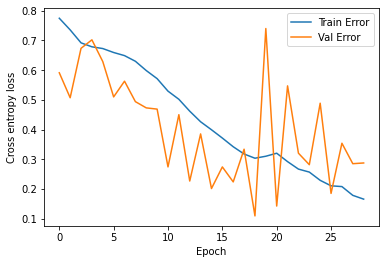

In [57]:
show_final_score(simple_cnn_history)

In [75]:
score = simple_cnn_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7852771878242493
Test accuracy: 0.6666666865348816
